In [1]:
import os
import re
from pprint import pprint

from matplotlib import rcParams
from cycler import cycler
rcParams["font.family"] = "Times New Roman"
rcParams["font.size"] = 12
rcParams['axes.prop_cycle'] = cycler(color='k')
import matplotlib.pyplot as plt

def is_rule(line):
    if line[0] == '#':
        return False
    return line.find('->') != -1 and line.find('alert') != -1

def parse_content_hex(content_val):
    is_hex = False
    pos = 0
    parsed_val = ''
    while pos < len(content_val):
        if content_val[pos] == ' ':
            pos += 1
            continue

        if content_val[pos] == '|':
            is_hex = not is_hex
            pos += 1
        else:
            if is_hex:
                hex_byte_str = content_val[pos:pos+2]
                parsed_val += chr(int(hex_byte_str, 16))
                pos += 2
            else:
                parsed_val += content_val[pos]
                pos += 1
                
    return parsed_val

def parse_rule(rule):
    rule_dict = {}
    rule_dict['original_str'] = rule
    tokens = rule.split(' ')
    rule_dict['action'] = tokens[0]
    rule_dict['proto'] = tokens[1]
    rule_dict['src_domain'] = tokens[2]
    rule_dict['src_port'] = tokens[3]
    rule_dict['dst_domain'] = tokens[5]
    rule_dict['dst_port'] = tokens[6]

    rule_dict['options'] = []
    option_str = rule[rule.find('(')+1:len(rule)-2]
    #option_str = option_str.replace(' ', '')
    tokens = option_str.split(';')

    modifier_keywords = ['depth', 'within', 'offset', 'nocase', 
                            'fast_pattern', 'distance', 'rawbytes', 
                            'http_client_body', 'http_method', 'http_cookie',
                            'http_raw_cookie', 'http_header', 'http_raw_header',
                            'http_uri', 'http_raw_uri', 'http_stat_code',
                            'http_stat_msg']
    current_content = ''
    for i in tokens:
        if i == '':
            continue
        option_name = ''
        if i.find(':') == -1:
            option_name = i
            option_val = None
        else:
            pos = i.find(':')
            option_name = i[:pos]
            option_val = i[pos+1:]
            if option_val[0] == '\"':
                option_val = option_val[1:len(option_val)-1]
        
        if len(option_name) > 0 and option_name[0] == ' ':
            option_name = option_name[1:]

        if option_name == 'content':
            current_content = i
            #rule_dict['options'].append({'name': option_name, 'value': parse_content_hex(option_val)})
            rule_dict['options'].append({'name': option_name, 'value': option_val})
        elif option_name in modifier_keywords:
            if current_content != '':
                for opt in reversed(rule_dict['options']):
                    if opt['name'] == 'content':
                        if 'modifiers' not in opt:
                            opt['modifiers'] = []
                        opt['modifiers'].append({'name': option_name, 'value': option_val})
                        break
            else:
                print('[ERROR] no content before: {}'.format(i))
                pprint(rule_dict)
        else:
            current_content = ''
            #if option_name == 'http_encode':
            #    print(rule)
            rule_dict['options'].append({'name': option_name, 'value': option_val})

    return rule_dict

def read_all_rule_files():
    print('Current dir: {}'.format(os.getcwd()))

    all_rules = []
    with open('registered_orig.rules') as f:
        for line in f:
            if is_rule(line):
                rule_dict = parse_rule(line)
                all_rules.append(rule_dict)
            
    print('Number of rules: {}'.format(len(all_rules)))
    return all_rules

print(os.getcwd())
#os.chdir('/home/vagrant/eBPF-IDS/snort/rules')
#os.chdir('C:\\Users\\jeff\\Desktop\\eBPF-IDS\\snort\\rules')
#os.chdir('C:\\Users\\jeff\\Desktop\\')
all_rules = read_all_rule_files()
#print(all_rules[10]['original_str'])
#pprint(all_rules[10])

C:\Users\Asus\Desktop\eBPF-Thesis\Figure\Jupyter
Current dir: C:\Users\Asus\Desktop\eBPF-Thesis\Figure\Jupyter
Number of rules: 50882


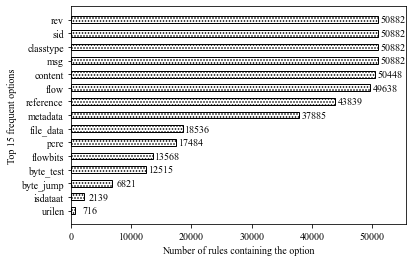

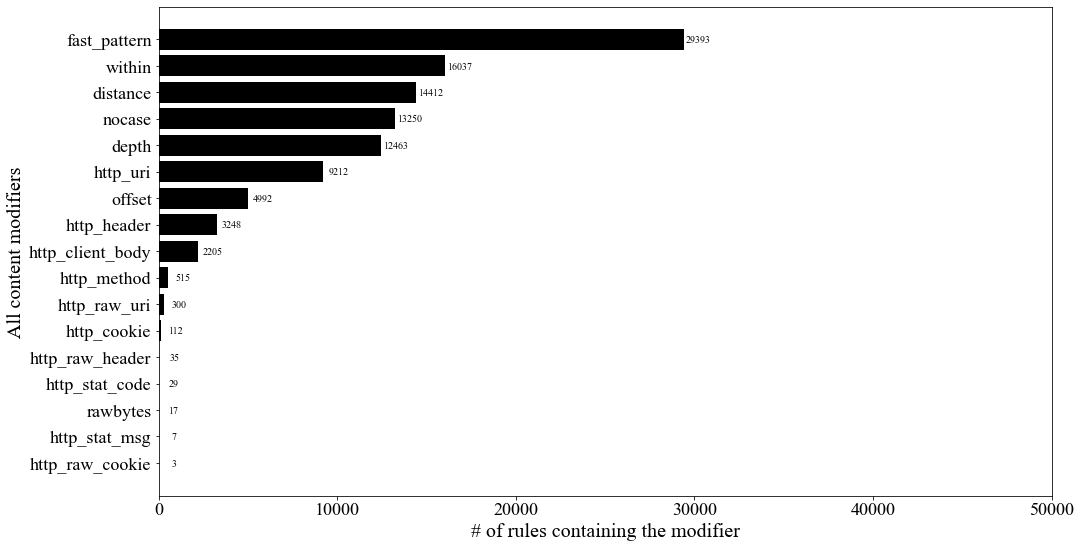

In [2]:
def count_options(rules):
    count_dict = {}
    for rule_dict in rules:
        rule_options = rule_dict['options']
        local_count = {}
        for opt in rule_options:
            if opt['name'] not in local_count:
                local_count[opt['name']] = 0
            local_count[opt['name']] += 1
        
        for key in local_count:
            if key not in count_dict:
                count_dict[key] = 0
            count_dict[key] += 1
            
    return count_dict

def count_content_modifiers(rules):
    count_dict = {}
    for rule_dict in rules:
        local_count = {}
        rule_options = rule_dict['options']
        for opt in rule_options:
            if opt['name'] == 'content' and 'modifiers' in opt:
                for mod in opt['modifiers']:
                    if mod['name'] not in local_count:
                        local_count[mod['name']] = 0
                    local_count[mod['name']] += 1
                    
        for key in local_count:
            if key not in count_dict:
                count_dict[key] = 0
            count_dict[key] += 1
                    
    return count_dict

def autolabel(rects, plt):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        plt.annotate('{}'.format(width),
                    xy = (width, rect.get_y() + rect.get_height()/2),
                    xytext=(15, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='center')

option_count = count_options(all_rules)
sorted_list = sorted(option_count.items(), key=lambda d: d[1])
sorted_list = sorted_list[len(sorted_list)-15:]
#plt.figure(figsize=(6.4, 5))
#plt.figure()
rects = plt.barh(list(zip(*sorted_list))[0], list(zip(*sorted_list))[1], log=False, height=0.5, color='w', hatch='....', edgecolor = 'k')
autolabel(rects, plt)
#plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
plt.xlabel('Number of rules containing the option')
plt.ylabel('Top 15 frequent options')
plt.xlim(0, 55500)
plt.savefig('top_options.pdf', bbox_inches='tight')
plt.show()

modifier_count = count_content_modifiers(all_rules)
sorted_list = sorted(modifier_count.items(), key=lambda d: d[1])
plt.figure(figsize=(16,9))
rects = plt.barh(list(zip(*sorted_list))[0], list(zip(*sorted_list))[1], log=False)
autolabel(rects, plt)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('# of rules containing the modifier', fontsize=20)
plt.ylabel('All content modifiers', fontsize=20)
plt.xlim(0, 50000)
plt.show()

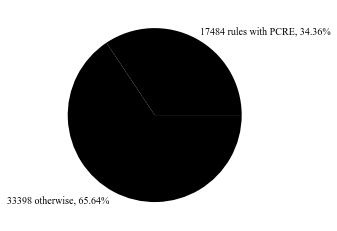

{'action': 'alert',
 'dst_domain': '$EXTERNAL_NET',
 'dst_port': '$HTTP_PORTS',
 'options': [{'name': 'msg',
              'value': 'APP-DETECT Absolute Software Computrace outbound '
                       'connection - search.namequery.com'},
             {'name': 'flow', 'value': 'to_server,established'},
             {'modifiers': [{'name': 'fast_pattern', 'value': 'only'},
                            {'name': 'http_header', 'value': None}],
              'name': 'content',
              'value': 'Host|3A| search.namequery.com|0D 0A|'},
             {'modifiers': [{'name': 'http_header', 'value': None}],
              'name': 'content',
              'value': 'TagId: '},
             {'name': 'metadata',
              'value': 'policy max-detect-ips drop, policy security-ips drop, '
                       'ruleset community, service http'},
             {'name': 'reference',
              'value': 'url,absolute.com/support/consumer/technology_computrace'},
             {'name': 're

In [3]:
rules_with_pcre = []
rules_without_pcre = []
for rule_dict in all_rules:
    options = rule_dict['options']
    has_pcre = False
    for opt in options:
        if opt['name'] == 'pcre':
            has_pcre = True
            break
    if has_pcre:
        rules_with_pcre.append(rule_dict)
    else:
        rules_without_pcre.append(rule_dict)
        
plt.figure()
pcre_count = (len(rules_with_pcre), len(rules_without_pcre))
pcre_ratio = (pcre_count[0]/sum(pcre_count)*100, pcre_count[1]/sum(pcre_count)*100)
plt.pie(pcre_count, 
        labels=['{} rules with PCRE, {:.2f}%'.format(pcre_count[0], pcre_ratio[0]), '{} otherwise, {:.2f}%'.format(pcre_count[1], pcre_ratio[1])])
plt.show()
pprint(rules_without_pcre[0])

In [4]:
rules_without_content = []
for rule in rules_without_pcre:
    options = rule['options']
    has_content = False
    for opt in options:
        if opt['name'] == 'content':
            has_content = True
            break
    if has_content == False:
        rules_without_content.append(rule)
print(len(rules_without_content))
#pprint(rules_without_content[0])

364


In [5]:
supported_options = ['sid', 'classtype', 'msg', 'metadata', 'rev', 'content', 'flow', 
                     'reference', 'pcre', 'byte_test', 'file_data']
supported_modifiers = ['fast_pattern', 'http_uri', 'nocase', 'depth', 'distance', 
                       'http_header', 'within', 'offset', 'http_client_body', 'http_method', 
                       'http_raw_uri']
supported_rules = []
unsupported_rules = []
def count_support(rules):
    count_dict = {}
    for rule_dict in rules:
        supported = True
        rule_options = rule_dict['options']
        has_content = False
        for opt in rule_options:
            if opt['name'] not in supported_options:
                supported = False
                break
            if opt['name'] == 'content':
                has_content = True
                if 'modifiers' in opt:
                    for mod in opt['modifiers']:
                        if mod['name'] not in supported_modifiers:
                            supported = False
                            break
                            
            if opt['name'] == 'metadata' and opt['value'].find('policy max-detect-'):
                supported = False
                break
                
            if not supported:
                break
        if not has_content:
            supported = False
            
        if supported:
            supported_rules.append(rule_dict)
        else:
            unsupported_rules.append(rule_dict)
    print('Supported: {}'.format(len(supported_rules)))
    print('unSupported: {}'.format(len(unsupported_rules)))
    
    with open('supported.rules', 'w') as f:
        for i in supported_rules:
            f.write(i['original_str'])
    
           
#all_rules = all_rules[:1000]
count_support(all_rules)

Supported: 19159
unSupported: 31723
